# Rutherford scattering

Notebook by: Óscar Amaro (2020)

In this notebook we show how to obtain the Rutherford cross section in ZPIC.

ZPIC does not have a collision module, but we can simulate collisions with an external Coulomb field. This means this notebook does not demonstrate any plasma physics, but rather a purely classical collision.

Links:
- Check out [ZPIC on Github](https://github.com/zpic-plasma/zpic)
- And your account on [ZPIC server](https://zpic.tecnico.ulisboa.pt/hub/login)

Other links:
- Rutherford scattering on [Wikipedia](https://en.wikipedia.org/wiki/Rutherford_scattering)

Bibliography:
- Callen [Chapter 2](http://homepages.cae.wisc.edu/~callen/book.html)
- Goldstein 'Classical Mechanics' §3.10

In this notebook you will learn:
- scattering from coulomb field
- variable normalization
- apply external field
- define custom density profiles
- turn off current deposition (downgrading zpic to a particle pusher)
- build histograms and compare with theoretical cross-section

To consolidate what you've learned about rutherford scattering, the notebook includes some exercises.

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from IPython.display import HTML

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import em2d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import math
# style
fntsz=20

# Notation

- $b$ is the impact parameter
- $\theta$ is the scattering angle 
- $d\sigma/d\Omega$  is the differential cross-section
- $\phi$ is the azimuthal angle

The schematic below was taken from Griffiths' 'Quantum Mechanics', Chapter 11.

![title](scattering.png)

### __Normalization__
Before beginning it is important to normalize the relevant equations, starting with the Coulomb field.
$$E=\frac{Z e}{r^2} \Leftrightarrow \frac{m_e c \omega_p}{e} E' = \frac{\omega_p^2 e}{c^2} \frac{Z}{r'^2} \Leftrightarrow E' = \frac{\omega_p e^2}{m_e c^3} \frac{Z}{r'^2}$$

now, as $\omega_p^2 = n_e e^2/m_e$ and $[n_e] = L^{-3} = \omega_p^3 c^{-3}$ we have $\omega_p^2 = \frac{\omega_p^3 c^{-3} e^2}{m_e} \Rightarrow \omega_p = \frac{m_e c^3}{e^2}$

Therefore $$ E' = \frac{Z}{r'^2}$$

### __Impact parameter__
In the case of Rutherford scattering we have
$$
b=\left(q_{1} q_{2} / 8 \pi \epsilon_{0} \epsilon \right) \cot (\theta / 2)
$$
where $\epsilon=\frac{1}{2}m_e v_0^2$ is the kinetic energy and $v_0$ is the velocity of the incoming particle. We can rewrite this as
$$b'= \frac{z Z}{v_0'^2} \frac{1}{\tan \theta/2}$$

### __Cross section__
The differential cross-section is defined as
$$
\frac{d\sigma}{d\Omega}=\frac{b}{\sin \theta}\left|\frac{d b}{d \theta}\right|
$$

In the case of Rutherford scattering we have
$$
\frac{d\sigma}{d\Omega}=\left[\frac{q_{1} q_{2}}{16 \pi \epsilon_{0} \epsilon \sin ^{2}(\theta / 2)}\right]^{2}
$$

but instead of normalizing the equation, the particle histogram will be normalized numerically.

### Exercise 1

In order to run the simulation and draw some animations we need to turn off some lines of code that do not change the physics dramatically.
The meaning of these changes will become clearer later on.

Please follow these instructions:
- Turn off current deposition. Go to the `em2d` folder, run `make clean`. In `simulation.c`, comment out the lines `current_update( &sim -> current );` and `emf_advance( &sim -> emf, &sim -> current );`
- Turn off particle sorting. In `particles.c`, comment out the line `if ( ! (spec -> iter % 16) ) spec_sort( spec );` . Run `make`
- Go to the `python` folder. Run `make clean`, `make`
- We are ready to go!

We start by shooting only one electron

In [2]:
def chooseb(b):
    #display(b)
    return b
pywidg = interactive(chooseb, b=widgets.IntSlider(min=0, max=10, step=1, value=5))
display(pywidg)

interactive(children=(IntSlider(value=5, description='b', max=10), Output()), _dom_classes=('widget-interact',…

In [3]:
# Grid
nxx = 32*6
nyy = 128*4*4
# box
boxL = 12.8*4; boxH = 35
xsource = boxL/2.0; ysource = boxH/6.0
xbeam = boxL/20; ybeam=ysource+pywidg.result;
beamL = boxL/nxx; beamH = boxH/nyy
# scatterer charge
Z = -0.3
# Time step
ddt = 10 / ( 1/(boxL/nxx)**2 + 1/(boxH/nyy)**2 )
tmax = 65.0
titer = np.int(tmax/ddt)
# initial beam momentum
ufl0 = 0.5;

# Custom density profiles along x and y
def xdensity(x):
    return (np.heaviside(x-(xbeam-beamL),0.5)-np.heaviside(x-(xbeam),0.5))
def ydensity(y):
    return (np.heaviside(y-(ybeam),0.5)-np.heaviside(y-(ybeam+beamH),0.5))

# Background plasma
density = em2d.Density( type = "custom", custom_x = xdensity, custom_y = ydensity )
electrons = em2d.Species( "electrons", -1.0, ppc = [2,2], ufl = [ufl0,0.0,0.0], density = density )
# Initialize simulation data
sim = em2d.Simulation( nx = [nxx,nyy], box = [boxL,boxH], dt = ddt, 
                       species = electrons )
npart = len(electrons.particles['x'])
print('#electrons=',npart)

# create array to store the trajectories of the particles
trajectory = np.zeros((21,npart,2))

#electrons= 1


### Exercise 3
- Write down the right form of the electric field

In [4]:
# Electric field
def ext_E1(ix,dx,iy,dy):
    x = ix*dx - xsource;
    y = iy*dy - ysource;
    r=math.sqrt(x**2+y**2)
    phi=math.atan2(x,y)
    mod_r = Z/r**2
    return [mod_r*math.sin(phi),mod_r*math.cos(phi),0]
# Magnetic field
def ext_B1(ix,dx,iy,dy):
    return [0.0,0.0,0.0]
# apply fields to simulation
ext = em2d.ExternalField(E_type = 'custom',E_custom=ext_E1,B_type = 'custom',B_custom=ext_B1)
sim.emf.set_ext_fld( ext )

In [5]:
# Run the simulation
while sim.n < titer:
    print('n = {:d}, t = {:g},  {:g}'.format(sim.n,sim.t,tmax), end = '\r')
    if np.mod(sim.n,np.int(titer/20))==0:
        electronx = (electrons.particles['ix'] + electrons.particles['x']) * boxL/nxx
        electrony = (electrons.particles['iy'] + electrons.particles['y']) * boxH/nyy
        trajectory[np.int(sim.n/np.int(titer/20))-1,:,:] = np.transpose(np.array([electronx,electrony]))
    sim.iter()
# save last 
electronx = (electrons.particles['ix'] + electrons.particles['x']) * boxL/nxx
electrony = (electrons.particles['iy'] + electrons.particles['y']) * boxH/nyy
trajectory[-1,:,:] = np.transpose(np.array([electronx,electrony]))

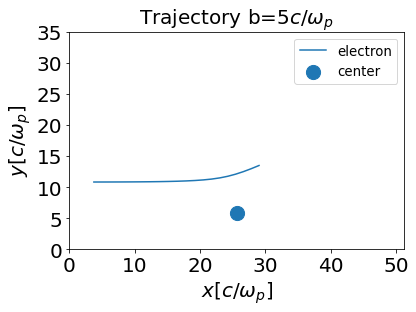

In [7]:
# plot the trajectory
plt.plot(trajectory[:,0,0],trajectory[:,0,1],color='#1f77b4',label='electron')
plt.scatter([xsource],[ysource],s=200,label='center')
plt.xlim([0,boxL])
plt.ylim([0,boxH])
plt.xlabel(r'$x[c/\omega_p]$',fontsize=fntsz)
plt.ylabel(r'$y[c/\omega_p]$',fontsize=fntsz)
plt.title('Trajectory b='+str(pywidg.result)+'$c/\omega_p$',fontsize=fntsz)
plt.xticks(fontsize=fntsz)
plt.yticks(fontsize=fntsz)
plt.legend(fontsize=fntsz/1.5)
plt.show()

In [36]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim([0,boxL])
ax.set_ylim([0,boxH])
line, = ax.plot([], [], lw=2)
ax.plot(trajectory[:,0,0],trajectory[:,0,1],color='#1f77b4',label='electron',alpha=0.2)
ax.scatter([xsource],[ysource],s=200,label='center')
ax.set_xlabel(r'$x[c/\omega_p]$',fontsize=fntsz)
ax.set_ylabel(r'$y[c/\omega_p]$',fontsize=fntsz)
ax.set_title('Trajectory b='+str(pywidg.result)+'$c/\omega_p$',fontsize=fntsz)
ax.tick_params(labelsize='medium')
ax.legend(fontsize=fntsz/1.5)
plt.close()
# initialization function: plot the background of each frame
def init():
    #line.set_data([], [])
    #return (line,)
    return ()
# animation function. This is called sequentially
def animate(i):
    line.set_data(trajectory[max(0,i-5):i,0,0], trajectory[max(0,i-5):i,0,1])
    return (line,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(trajectory[:,0,0]), interval=60, blit=True);
rc('animation', html='html5')
anim

### Exercise 4
- Try choosing different initial positions of the incoming particle

We now include many particles in our simulation.

In [16]:
# Grid
nxx = 32*6
nyy = 128*4*4
# box
boxL = 12.8*4
boxH = 35
xsource = boxL/2.0
ysource = boxH/6.0
xbeam = boxL/20
beamL = boxL/nxx
beamH = 0.6*boxH
nbins = 40 # #bins for histogram

# scatterer
Z = -0.3

# Time step
ddt = 10 / ( 1/(boxL/nxx)**2 + 1/(boxH/nyy)**2 )
tmax = 65.0
titer = np.int(tmax/ddt)

# momentum
ufl0 = 0.5;

print('gamma =',np.sqrt(ufl0**2+1),',v/c=',ufl0/np.sqrt(ufl0**2+1))
print('dt =',ddt); print('#iterations =',titer)

gamma = 1.118033988749895 ,v/c= 0.4472135954999579
dt = 0.0029086812545243163
#iterations = 22346


### Exercise 2
- What is the time step and what is the number of iterations?
> Hint: add ``` print('dt =',ddt); print('#iterations =',titer) ``` to the code block above
- What is the Lorentz factor? Are we in the relativistic regime?
> Hint: add ``` print('gamma =',np.sqrt(ufl0**2+1),',v/c=',ufl0/np.sqrt(ufl0**2+1)) ``` to the code block above

### Define density functions

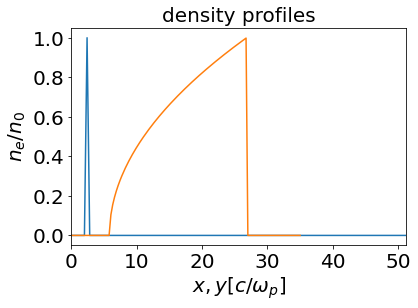

In [17]:
# Custom density profiles along x and y
def xdensity(x):
    return (np.heaviside(x-(xbeam-beamL),0.5)-np.heaviside(x-(xbeam),0.5))
def ydensity(y):
    return (np.heaviside(y-(ysource),0.5)-np.heaviside(y-(ysource+beamH),0.5))*np.sqrt(abs((y-ysource)/(beamH-beamH/1000)))

xlst = np.linspace(0,boxL,128)
plt.plot(xlst, xdensity(xlst))

ylst = np.linspace(0,boxH,128)
plt.plot(ylst, ydensity(ylst))
plt.xlabel(r'$x,y[c/\omega_p]$',fontsize=fntsz)
plt.ylabel(r'$n_e/n_0$',fontsize=fntsz)
plt.title(r'density profiles',fontsize=fntsz)
plt.xlim([0,boxL])
plt.xticks(fontsize=fntsz)
plt.yticks(fontsize=fntsz)
plt.show()

__Compare potential with kinetic energies__

If the potential component is much smaller, we can say the particles start at "infinity".

Normalization is trivial
$$ U' = \frac{Z}{r'} \ \text{and} \ K' = \frac{v'^2}{2}$$

In [13]:
r = np.sqrt((ybeam-ysource)**2+(xbeam-xsource)**2)
def ext_V1(r):
    return np.abs(Z)/r
# potential energy
print(max(ext_V1(r)))
# kinetic energy
print( 0.5*(ufl0/np.sqrt(ufl0**2+1))**2 )

0.012796471585345562
0.09999999999999999


In [18]:
# auxiliary function for plotting histograms
def histline(x):
    res=np.zeros((len(x)-1,1));
    for i in range(0,len(x)-1):
        res[i] = (x[i]+x[i+1])/2;
    return res

In [19]:
# Background plasma
density = em2d.Density( type = "custom", custom_x = xdensity, custom_y = ydensity )
electrons = em2d.Species( "electrons", -1.0, ppc = [16,16], ufl = [ufl0,0.0,0.0], density = density )

# Initialize simulation data
sim = em2d.Simulation( nx = [nxx,nyy], box = [boxL,boxH], dt = ddt, 
                       species = electrons )
npart = len(electrons.particles['x'])
print('#electrons=',npart) #remove

#electrons= 183389


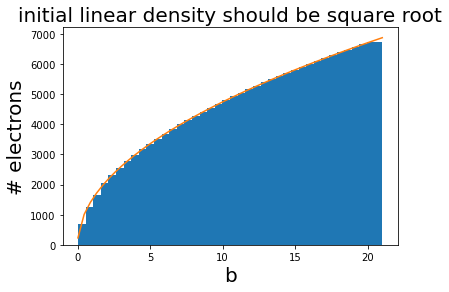

In [20]:
# initial linear density is square root
# get impact parameter
blst = (electrons.particles['iy'] + electrons.particles['y']) * boxH/nyy -ysource
blst2 = np.linspace(min(blst),max(blst)) # array in range of blst

plt.hist(blst,bins=nbins);
plt.plot(blst2,np.sqrt(blst2/max(blst2))*npart/(2/3)/nbins)
#plt.hist(trajectory[0,:,1],bins=50);
plt.title('initial linear density should be square root',fontsize=fntsz)
plt.xlabel(r'b',fontsize=fntsz)
plt.ylabel(r'# electrons',fontsize=fntsz)
plt.show()

In [21]:
# create array to store the trajectories of the particles
trajectory = np.zeros((21,npart,2))
print("memory(trajectory) =",trajectory.nbytes,'bytes=',trajectory.nbytes*1e-9,'GB') #remove

memory(trajectory) = 61618704 bytes= 0.061618704 GB


In [ ]:
# Run the simulation
while sim.n < titer:
    print('n = {:d}, t = {:g},  {:g}'.format(sim.n,sim.t,tmax), end = '\r')
    if np.mod(sim.n,np.int(titer/20))==0:
        electronx = (electrons.particles['ix'] + electrons.particles['x']) * boxL/nxx
        electrony = (electrons.particles['iy'] + electrons.particles['y']) * boxH/nyy
        trajectory[np.int(sim.n/np.int(titer/20))-1,:,:] = np.transpose(np.array([electronx,electrony]))
    sim.iter()
# save last 
electronx = (electrons.particles['ix'] + electrons.particles['x']) * boxL/nxx
electrony = (electrons.particles['iy'] + electrons.particles['y']) * boxH/nyy
trajectory[-1,:,:] = np.transpose(np.array([electronx,electrony]))

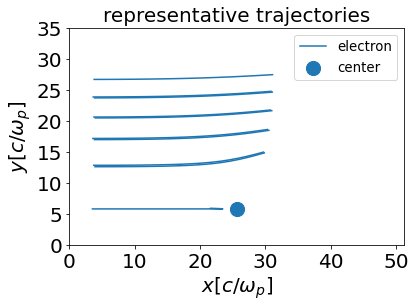

In [249]:
# plot some trajectories
# if the number of particles or the number of time steps is too high, plotting is slowed down
# select only 10 representative particles and 20 time steps
slct = 10
plt.plot(trajectory[:,0,0],trajectory[:,0,1],color='#1f77b4',label='electron')
for i in range(1,slct):
    plt.plot(trajectory[:,np.int(i*npart/10),0],trajectory[:,np.int(i*npart/10),1],color='#1f77b4')
plt.scatter([xsource],[ysource],s=200,label='center')
plt.xlim([0,boxL])
plt.ylim([0,boxH])
plt.xlabel(r'$x[c/\omega_p]$',fontsize=fntsz)
plt.ylabel(r'$y[c/\omega_p]$',fontsize=fntsz)
plt.title('representative trajectories',fontsize=fntsz)
plt.xticks(fontsize=fntsz)
plt.yticks(fontsize=fntsz)
plt.legend(fontsize=fntsz/1.5)
plt.show()

In [262]:
# create array for angle
thetalst = np.zeros(npart)
for i in range(npart):
    #deltax = electrons.particles['ux'][i]
    #deltay = electrons.particles['uy'][i]
    
    deltax = (trajectory[-1,i,0]-trajectory[-2,i,0])
    deltay = (trajectory[-1,i,1]-trajectory[-2,i,1])
    thetalst[i] = np.arctan2(deltay,deltax)

# create array for the theoretical estimation
thetalst2 = np.linspace(1e-3,np.pi)

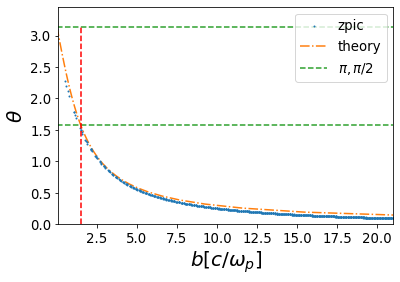

In [268]:
# theta(b)
plt.scatter(1.3*blst[0:-1:np.int(npart/1000)], thetalst[0:-1:np.int(npart/1000)],s=1,label='zpic')
plt.plot((-1*Z/(ufl0/np.sqrt(ufl0**2+1))**2)/np.tan(thetalst2/2), thetalst2, ls = '-.', color = '#ff7f0e', label='theory',zorder=-11)
plt.plot([min(0,min(blst)),max(blst)],[np.pi,np.pi],'--',color='#2ca02c',label=r'$\pi,\pi/2$')
plt.plot([min(0,min(blst)),max(blst)],[np.pi/2,np.pi/2],'--',color='#2ca02c')
plt.plot([(-1*Z/(ufl0/np.sqrt(ufl0**2+1))**2),(-1*Z/(ufl0/np.sqrt(ufl0**2+1))**2)],[0,np.pi],'--',color='red') # b90
#plt.xscale('log')
plt.ylim([0,np.pi*1.1])
plt.xlabel(r'$b[c/\omega_p]$',fontsize=fntsz)
plt.ylabel(r'$\theta$',fontsize=fntsz)
plt.xlim([1e-1,max(blst)])
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=fntsz/1.5)
plt.xticks(fontsize=fntsz/1.5)
plt.yticks(fontsize=fntsz/1.5)
plt.show()

In [264]:
# histograms output the bin content and the bin edges (size of bin content+1), which means one cannot immediately plot these two together
# to better compare simulation with theory, we take the output of the histogram and average the bin edges
nbins=50
thetamin=0.4
distY, distX, _ = plt.hist(thetalst[thetalst>thetamin], bins=nbins)
plt.close() # don't show histogram yet
distX2 = histline(distX)

# theoretical cross section/histogram
dsdO = np.sin(thetalst2)/np.sin(thetalst2/2)**4

In [265]:
from scipy.integrate import quad
def integrand(thet):
    return np.sin(thet)/np.sin(thet/2)**4
dsdOnrm = quad(integrand,distX2[0,0] , distX2[-1,0], args=())[0]

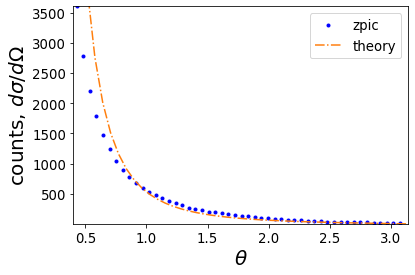

In [266]:
plt.plot(distX2,distY,'.b',label='zpic') #/max(dsdO)*max(distY)
plt.plot(thetalst2,dsdO/dsdOnrm*np.sum(distY)/nbins*np.pi,ls = '-.', color = '#ff7f0e',label='theory')
#plt.yscale('log') # log scale shows mismatchings better
plt.xlabel(r'$\theta$',fontsize=fntsz)
plt.ylabel(r'counts, $d\sigma/d\Omega$',fontsize=fntsz)
plt.xticks(fontsize=fntsz/1.5)
plt.yticks(fontsize=fntsz/1.5)
plt.xlim([thetamin,np.pi]) # we are not interested in angles very close to zero, unless you ran a simulation with that intent
plt.ylim([1,max(distY)]) # use this when vertical array spans several orders of magnitude
plt.legend(fontsize=fntsz/1.5)
plt.show()